In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow_datasets
!pip install matplotlib
!pip install pillow
!pip install pydot
!pip install pydotplus
!pip install graphviz

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal

## Imports and Configs

In [12]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

dataset_path = '../Data/Dataset/Predicted_Depth_Grayscale/'
map_path = '../PreprocessedImages/'
models_path = '../Models/'
model_name = 'SCD_Error_Correction_Faces'
training_data = 'Training/'
val_data = 'Testing/'

## Check GPU Running and Configs

From [here](https://github.com/tensorflow/tensorflow/issues/43174#issuecomment-691657692)

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CONFIGS

In [17]:
TRAINSET_SIZE = len(os.listdir(dataset_path + training_data))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
VALSET_SIZE = len(os.listdir(dataset_path + val_data))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")


# DATASET PARAMETERS
SEED = 123
TRAIN_LENGTH = TRAINSET_SIZE
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# MODEL PARAMETERS
OUTPUT_CHANNELS = 5

# TRAINING PARAMETERS
EPOCHS = 200
VAL_SUBSPLITS = 5 # CURRENTLY UNUSED
VALIDATION_STEPS = VALSET_SIZE//BATCH_SIZE//VAL_SUBSPLITS # CURRENTLY UNUSED


The Training Dataset contains 919 images.
The Validation Dataset contains 230 images.


## Define Helper Functions (parse image, normalize, load image for train or test, display image)

In [18]:
def parse_image(img_path: str) -> dict:
    """
    Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1, dtype=tf.dtypes.uint8)
    
    depth_path = tf.strings.regex_replace(img_path, 'Predicted_Depth', 'Original_Depth')
    depth_path = tf.strings.regex_replace(depth_path, '_Predicted_Depth', '_Original_Depth')
    depth = tf.io.read_file(depth_path)
    depth = tf.image.decode_png(depth, channels=1)

    return {'image': image, 'depth': depth}

def normalize(input_image, input_depth):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_depth = tf.cast(input_depth, tf.float32) / 255.0
    return input_image, input_depth

image_size = (512, 512)

@tf.function
def load_image_train(datapoint):
     ### Don't resize, crop instead! :^) 
    input_image = tf.image.resize(datapoint['image'], image_size)
    input_mask = tf.image.resize(datapoint['depth'], image_size)
#    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
#    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)
    input_mask = add_gaussian_blur(input_mask)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], image_size)
    input_mask = tf.image.resize(datapoint['depth'], image_size)
#    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
#    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)
    input_mask = add_gaussian_blur(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def add_gaussian_blur(image):
    image = tf.expand_dims(image, 0)
    blur = [tf.divide(tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype = tf.float32), 16.0)]
    blur = tf.expand_dims(blur, axis = -1)
    blur = tf.transpose(blur, [1,2,3,0])
    blurred_image = tf.nn.conv2d(image, blur, strides = (1,1), padding = 'SAME')[0]
    return blurred_image

## Define Helper Functions for displaying images and creating mask

In [19]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image (Decoded Depth)', 'True Depth', 'Decoded Depth', 'Predicted Depth', 'Decoded Diff', 'Predicted Diff']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        # plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, depth in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], depth[0], pred_mask[0]])
    else:
        display([sample_image, sample_mask, model.predict(sample_image[tf.newaxis, ...])[0]])
        
def evaluate_predictions(dataset=None, num=1):
    if dataset:
        for image, depth, in dataset.take(num):
            pred_depth = model.predict(image)[0]
            decoded_depth = tf.expand_dims(image[0,:,:,0], -1)
            
            display([image[0] * 255, depth[0] * 255, decoded_depth, pred_depth, (depth[0] * 255 - decoded_depth * 255), (depth[0] * 255 - pred_depth)])

def evaluate_all_data(dataset=None):
    decoded_rms_errors = []
    error_corrected_rms_errors = []
    
    if dataset:
        for batch in dataset:
            images = batch[0]
            depths = batch[1]
            
            for i in range(0, len(images)):
                image = images[i]
                depth = depths[i] * 255
                image = tf.reshape(image, [-1, 512, 512, 1]) # -1 to get None first dimensions         
                pred_depth = model.predict(image)[0]
                decoded_depth = image[0] * 255   
                
                decoded_rms_errors.append(calc_rms_error(depth, decoded_depth.numpy()))
                error_corrected_rms_errors.append(calc_rms_error(depth, pred_depth))
                
        print('Number of Images Tested: ', np.size(decoded_rms_errors))
        print('Average Decoded RMS Error: ', np.mean(decoded_rms_errors))
        print('Average Error Corrected RMS Error', np.mean(error_corrected_rms_errors))
    
                
def calc_rms_error(true_depth, pred_depth):
    diff = pred_depth - true_depth
    squared_diff = np.power(diff, 2)
    sum_squared_diff = np.sum(squared_diff)
    
    num_points = pred_depth.size
    
    return np.sqrt(sum_squared_diff / num_points)

## Setup Training and Validation Datasets

In [20]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.png", seed=SEED)
val_dataset = val_dataset.map(parse_image)

dataset = {"train": train_dataset, "val": val_dataset}

train = dataset['train'].map(load_image_train)
test = dataset['val'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

## Retrieve and display sample image

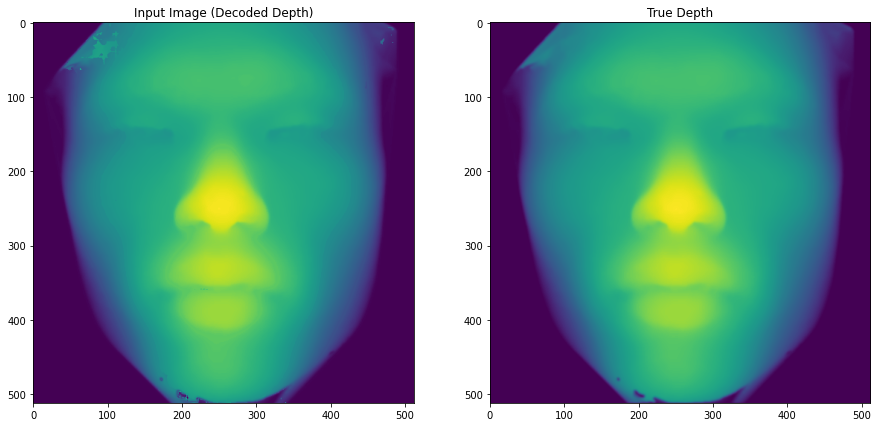

In [21]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

## Import Model???

In [22]:
model = keras.models.load_model(models_path + model_name)

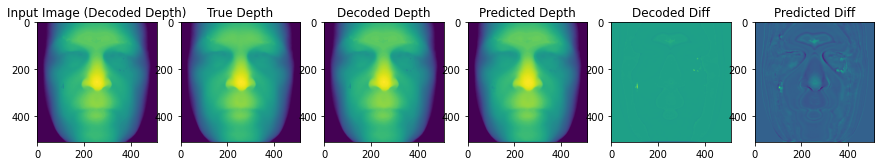

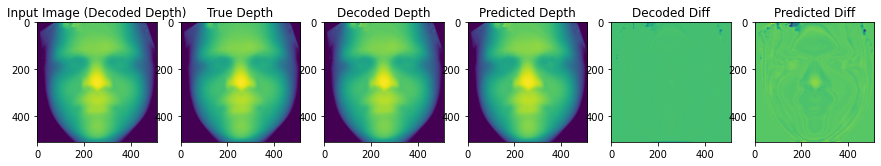

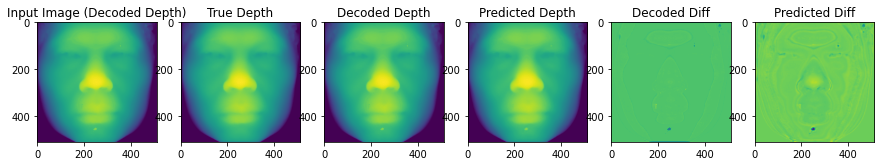

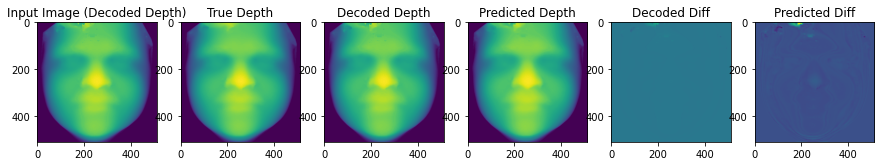

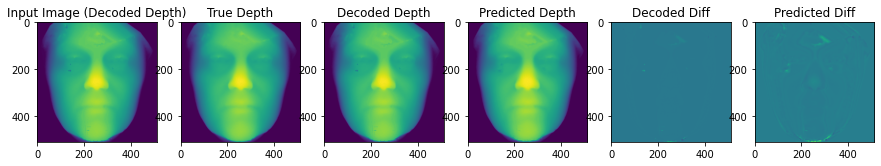

In [23]:
evaluate_predictions(test_dataset, 5)

In [25]:
evaluate_all_data(test_dataset)

Number of Images Tested:  230
Average Decoded RMS Error:  3.8113242933154394
Average Error Corrected RMS Error 2.1363050295590287
